In [ ]:
!pip install mysql-connector-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 44.8 MB/s eta 0:00:00


# **Database connection**

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.exc import SQLAlchemyError
import matplotlib.pyplot as plt

DB_PATH = 'healths.db'

def create_sqlalchemy_engine():
    """
    Create and return a SQLAlchemy engine for connecting to an SQLite database.
    """
    connection_string = f"sqlite:///{DB_PATH}"
    engine = create_engine(connection_string)
    return engine

def test_connection():
    """
    Test the SQLite database connection by creating a simple table.
    """
    try:
        engine = create_sqlalchemy_engine()
        with engine.connect() as connection:
            print("Database connection successful. SQLite is ready to use.")
    except SQLAlchemyError as e:
        print(f"Error connecting to the database: {e}")

def insert_to_sql(df, table_name, if_exists='replace'):
    """
    Insert a DataFrame into a specified table in the SQLite database.
    """
    try:
        engine = create_sqlalchemy_engine()
        df.to_sql(table_name, engine, if_exists=if_exists, index=False)
        print(f"Data inserted into table: {table_name}")
    except SQLAlchemyError as e:
        print(f"Error inserting data into {table_name}: {e}")


# **Transofrmation**

In [ ]:
import pandas as pd
from datetime import datetime

# Function to clean and standardize the conditions dataset
def clean_conditions_data(df):
    """
    Transforms and standardizes the conditions dataset for consistent analysis,
    ensuring clean and uniform patient and condition information.
    """
    # Rename columns to meaningful and standardized names
    df.rename(columns={
        'PATIENT': 'patient_id',
        'ENCOUNTER': 'encounter_id',
        'CODE': 'conditional_code',
        'DESCRIPTION': 'conditional_description'
    }, inplace=True)

    # Standardize text formatting for descriptions and patient IDs
    df['conditional_description'] = df['conditional_description'].str.title()
    df['patient_id'] = df['patient_id'].str.lower()

    # Drop unnecessary columns for analysis
    df.drop(columns=['START', 'STOP', 'conditional_code', 'conditional_description'], inplace=True)

    return df

# Function to clean and process medications data
def clean_medications_data(df):
    """
    Processes medication data to create a clean, standardized dataset
    with normalized text, converted numeric values, and consistent formatting.
    """
    # Rename columns for clarity and consistency
    df.rename(columns={
        'START': 'start_date',
        'STOP': 'end_date',
        'PATIENT': 'patient_id',
        'PAYER': 'payer_id',
        'ENCOUNTER': 'encounter_id',
        'CODE': 'drug_code',
        'DESCRIPTION': 'drug_description',
        'BASE_COST': 'base_cost',
        'PAYER_COVERAGE': 'payer_coverage',
        'DISPENSES': 'dispensed_quantity',
        'TOTALCOST': 'total_cost',
        'REASONCODE': 'reason_code',
        'REASONDESCRIPTION': 'reason_description'
    }, inplace=True)

    # Normalize text data (lowercase and titlecase where applicable)
    columns_to_lowercase = ['patient_id', 'payer_id', 'encounter_id', 'drug_description']
    for col in columns_to_lowercase:
        df[col] = df[col].str.lower()

    df['drug_description'] = df['drug_description'].str.title()

    # Convert specific columns to numeric types, handling errors gracefully
    int_columns = ['drug_code', 'dispensed_quantity', 'reason_code']
    df[int_columns] = df[int_columns].apply(pd.to_numeric, errors='coerce', downcast='integer')

    float_columns = ['base_cost', 'total_cost']
    df[float_columns] = df[float_columns].apply(pd.to_numeric, errors='coerce', downcast='float')

    # Convert date columns to datetime objects and remove timezone information
    df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce').dt.tz_localize(None)
    df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce').dt.tz_localize(None)

    # Drop irrelevant or redundant columns
    df.drop(columns=['reason_description', 'reason_code', 'payer_coverage', 'start_date', 'end_date'], inplace=True)

    return df

# Function to clean and standardize patient data
def clean_patients_data(df):
    """
    Refines patient data by standardizing names, cleaning geographical information,
    and ensuring consistent data formatting across all patient records.
    """
    # Rename columns to standardized names
    df.rename(columns={
        'PATIENT_ID': 'patient_id',
        'BIRTHDATE': 'birth_date',
        'DEATHDATE': 'death_date',
        'FIRST': 'first_name',
        'LAST': 'last_name',
        'BIRTHPLACE': 'birth_place',
        'COUNTY': 'county',
        'LAT': 'latitude',
        'LON': 'longitude',
        'INCOME': 'income'
    }, inplace=True)

    # Remove irrelevant columns
    df.drop(columns=['GENDER'], inplace=True)

    # Standardize patient ID to lowercase
    df['patient_id'] = df['patient_id'].str.lower()

    # Convert birth and death dates to datetime format
    df['birth_date'] = pd.to_datetime(df['birth_date'], errors='coerce')
    df['death_date'] = pd.to_datetime(df['death_date'], errors='coerce')

    # Standardize names by removing trailing digits and capitalizing
    df['first_name'] = df['first_name'].str.replace(r'\d+$', '', regex=True).str.capitalize()
    df['last_name'] = df['last_name'].str.replace(r'\d+$', '', regex=True).str.capitalize()

    # Clean and standardize birth place and county information
    df['birth_place'] = df['birth_place'].str.strip().str.title()
    df['county'] = df['county'].apply(lambda x: x[:-6].strip() if isinstance(x, str) and x.endswith('County') else x)

    # Process and clean latitude and longitude values
    df['latitude'] = df['latitude'].apply(lambda x: str(x).lstrip("'") if isinstance(x, str) else x)
    df['longitude'] = pd.to_numeric(df['longitude'].astype(str).str.strip(), errors='coerce')

    # Convert income to numeric type
    df['income'] = pd.to_numeric(df['income'], errors='coerce')

    # Ensure all column names are lowercase
    df.columns = df.columns.str.lower()

    return df

# Function to clean and process symptoms data
def clean_symptoms_data(df):
    """
    Processes symptoms data to create a clean, structured dataset
    with normalized patient identifiers and symptom information.
    """
    # Rename columns to standardized names
    df.rename(columns={
        'PATIENT': 'patient_id',
        'RACE': 'race',
        'ETHNICITY': 'symptoms_ethnicity',
        'AGE_BEGIN': 'start_age',
        'AGE_END': 'end_age',
        'PATHOLOGY': 'pathology',
        'NUM_SYMPTOMS': 'num_symptoms',
        'SYMPTOMS': 'symptoms'
    }, inplace=True)

    # Standardize text formatting for pathology and patient IDs
    df['pathology'] = df['pathology'].str.title()
    df['patient_id'] = df['patient_id'].str.lower()

    # Drop irrelevant columns
    df.drop(columns=['GENDER', 'race', 'symptoms_ethnicity'], inplace=True)

    # Ensure all column names are lowercase
    df.columns = df.columns.str.lower()

    return df

# Function to clean and transform encounter data
def clean_encounter_data(df):
    """
    Transforms encounter data to provide a clean, consistent dataset
    with standardized patient and encounter information.
    """
    # Rename columns to standardized names
    df.rename(columns={
        'Id': 'encounter_id',
        'START': 'start_date',
        'STOP': 'stop_date',
        'PATIENT': 'patient_id',
        'ORGANIZATION': 'organization',
        'REASONDESCRIPTION': 'encounter_description',
        'REASONCODE': 'reason_code',
        'DESCRIPTION': 'description',
        'ENCOUNTERCLASS': 'encounter_class',
        'PAYER': 'payer_id',
        'PROVIDER': 'provider_id',
        'CODE': 'code',
        'BASE_ENCOUNTER_COST': 'base_encounter_cost',
        'TOTAL_CLAIM_COST': 'total_claim_cost',
        'PAYER_COVERAGE': 'payer_coverage'
    }, inplace=True)

    # Standardize patient ID to lowercase
    df['patient_id'] = df['patient_id'].str.lower()

    # Ensure all column names are lowercase
    df.columns = df.columns.str.lower()

    # Drop redundant columns
    df.drop(columns=['encounter_description'], inplace=True)

    return df

# Function to merge patient data with gender data
def merge_patients_and_gender(df_patients, df_gender):
    """
    Combines patient information with gender data using patient identifier,
    creating a comprehensive consolidated dataset.
    """
    # Merge datasets on patient ID
    df_merged = pd.merge(df_patients, df_gender, left_on='patient_id', right_on='Id', how='inner')

    # Drop unnecessary columns after merging
    df_merged.drop(columns=['Id'], inplace=True)

    print("Successfully merged the datasets based on 'patient_id'.")

    return df_merged

# Generalized function to merge two datasets
def merge_datasets(dataset1, dataset2, key_columns, how='left'):
    """
    Flexible dataset merging function that allows different join strategies
    based on specified key columns.
    """
    return dataset1.merge(dataset2, on=key_columns, how=how)

# **Link to the 5 datasets**

In [ ]:
CONDITION_FILE = "conditions.csv"
ENCOUNTER_FILE = "encounters.parquet"
MEDICATION_FILE = "medications.csv"
PATIENT_FILE = "patients.csv"
SYMPTOM_FILE = "symptoms.csv"
PATIENTS_GEN_FILE = "patient_gender.csv"

def read_files():
  """
  Reads input files and returns the corresponding dataframes.
  """
  print("Reading input files...")
  conditions = pd.read_csv(CONDITION_FILE)
  encounters = pd.read_parquet(ENCOUNTER_FILE)
  medications = pd.read_csv(MEDICATION_FILE)
  patients = pd.read_csv(PATIENT_FILE, encoding="ISO-8859-1")
  symptoms = pd.read_csv(SYMPTOM_FILE)
  patients_gender = pd.read_csv(PATIENTS_GEN_FILE)
  print("Successfully completed reading files.")
  return conditions, encounters, medications, patients, symptoms, patients_gender

def transform_data(conditions, encounters, medications, patients, symptoms, patients_gender):
  """
  Cleans and transforms data.
  """
  print("Starting data transformation...")
  conditions = clean_conditions_data(conditions)
  medications = clean_medications_data(medications)
  patients = clean_patients_data(patients)
  symptoms = clean_symptoms_data(symptoms)
  encounters = clean_encounter_data(encounters)
  print("Data cleaning completed.")

  print("Merging patients with gender data...")
  patients = merge_patients_and_gender(patients, patients_gender)

  df_cleaned_data = {
      'conditions': conditions,
      'encounters': encounters,
      'medications': medications,
      'patients': patients,
      'symptoms': symptoms
  }

  for table_name, df in df_cleaned_data.items():
      name = f"{table_name}_cleaned.csv"
      # print(f"Saving cleaned {table_name} to {name}...")
      df.to_csv(name, index=False)
      insert_to_sql(df, table_name)

  return conditions, encounters, medications, patients, symptoms

def merge_all_data(patients, symptoms, encounters, conditions, medications):
  """
  Merges all datasets into a single master dataframe.
  """
  print("Merging datasets...")
  merged_df = patients
  for dataset, key in [
      (symptoms, 'patient_id'),
      (encounters, 'patient_id'),
      (conditions, ['encounter_id', 'patient_id']),
      (medications, ['encounter_id', 'patient_id', 'payer_id'])
  ]:
      print(f"Merging with dataset using key {key}...")
      merged_df = merge_datasets(merged_df, dataset, key)

  print("Saving merged master dataset to 'masters.csv'...")
  merged_df.to_csv('masters.csv', index=False)
  print("Master dataset saved successfully.")
  return merged_df


def count_distinct_patients(df):
  print('1. Count Distinct Patients')
  distinct_patients = df['patient_id'].nunique()
  print(f"Number of distinct patients: {distinct_patients}")
  return distinct_patients

def plot_distinct_medications(df):
  print("2. Plotting distinct medications over time...")
  df['start_date'] = pd.to_datetime(df['start_date'])
  medications_over_time = (
      df.groupby('start_date')['drug_code']
      .nunique()
      .reset_index()
      .rename(columns={'drug_code': 'distinct_medications'})
  )

  plt.figure(figsize=(12, 6))
  plt.plot(medications_over_time['start_date'], medications_over_time['distinct_medications'], marker='o')
  plt.title('Distinct Medications Over Time', fontsize=16)
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Number of Distinct Medications', fontsize=14)
  plt.grid()
  plt.show()

  duplicates = df[df.duplicated(subset=['drug_code', 'drug_description'], keep=False)]
  print(f"Number of duplicate medication entries: {len(duplicates)}")
  if not duplicates.empty:
      print("Consider revisiting the cleaning logic for medications.")

def plot_race_gender_distribution(df):
  print("3. Creating pie charts for race and gender distributions...")
  race_distribution = df['race'].value_counts(normalize=True) * 100
  gender_distribution = df['GENDER'].value_counts(normalize=True) * 100

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  race_distribution.plot.pie(autopct='%1.1f%%', startangle=140, cmap='viridis')
  plt.title('Patients by Racial Category', fontsize=14)
  plt.ylabel('')

  plt.subplot(1, 2, 2)
  gender_distribution.plot.pie(autopct='%1.1f%%', startangle=140, colors=['lightblue', 'pink'])
  plt.title('Patients by Gender', fontsize=14)
  plt.ylabel('')

  plt.tight_layout()
  plt.show()

def calculate_symptom_percentage(df):
  print("4. Calculating percentage of patients with all 4 symptom categories ≥ 30...")
  patients_with_symptoms = df[
      (df['num_symptoms'] >= 30)
  ].groupby('patient_id').filter(lambda x: x['num_symptoms'].count() >= 4)

  percentage_with_all_symptoms = (
      patients_with_symptoms['patient_id'].nunique() / df['patient_id'].nunique()
  ) * 100
  print(f"Percentage of patients with all 4 symptom categories ≥ 30: {percentage_with_all_symptoms:.2f}%")
  return percentage_with_all_symptoms


def main():
  """
  Main function to execute the entire pipeline and data analysis.
  """
  conditions, encounters, medications, patients, symptoms, patients_gender = read_files()

  conditions, encounters, medications, patients, symptoms = transform_data(
      conditions, encounters, medications, patients, symptoms, patients_gender
  )

  master_data = merge_all_data(patients, symptoms, encounters, conditions, medications)

  print("Data processing pipeline completed successfully.")
  print("Starting data analysis and visualization...\n")
  master_df = pd.read_csv('masters.csv')

  count_distinct_patients(master_df)
  plot_distinct_medications(master_df)
  plot_race_gender_distribution(master_df)
  calculate_symptom_percentage(master_df)

  print("\nData analysis and visualization completed.")

# **Main funtion**

Reading input files...
Successfully completed reading files.
Starting data transformation...
Data cleaning completed.
Merging patients with gender data...
Successfully merged the datasets based on 'patient_id'.
Data inserted into table: conditions
Data inserted into table: encounters
Data inserted into table: medications
Data inserted into table: patients
Data inserted into table: symptoms
Merging datasets...
Merging with dataset using key patient_id...
Merging with dataset using key patient_id...
Merging with dataset using key ['encounter_id', 'patient_id']...
Merging with dataset using key ['encounter_id', 'patient_id', 'payer_id']...
Saving merged master dataset to 'masters.csv'...
Master dataset saved successfully.
Data processing pipeline completed successfully.
Starting data analysis and visualization...

1. Count Distinct Patients
Number of distinct patients: 10000
2. Plotting distinct medications over time...


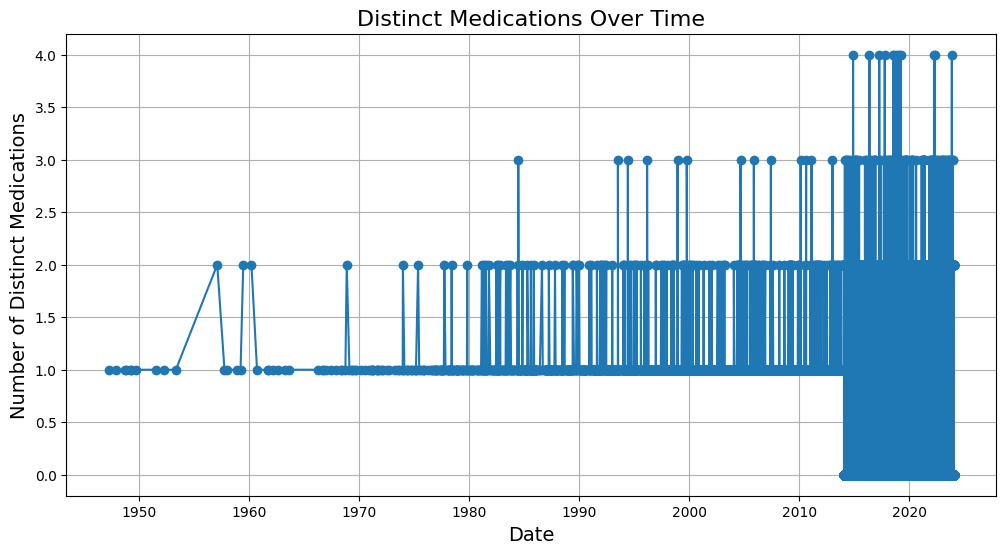

Number of duplicate medication entries: 123809
Consider revisiting the cleaning logic for medications.
3. Creating pie charts for race and gender distributions...


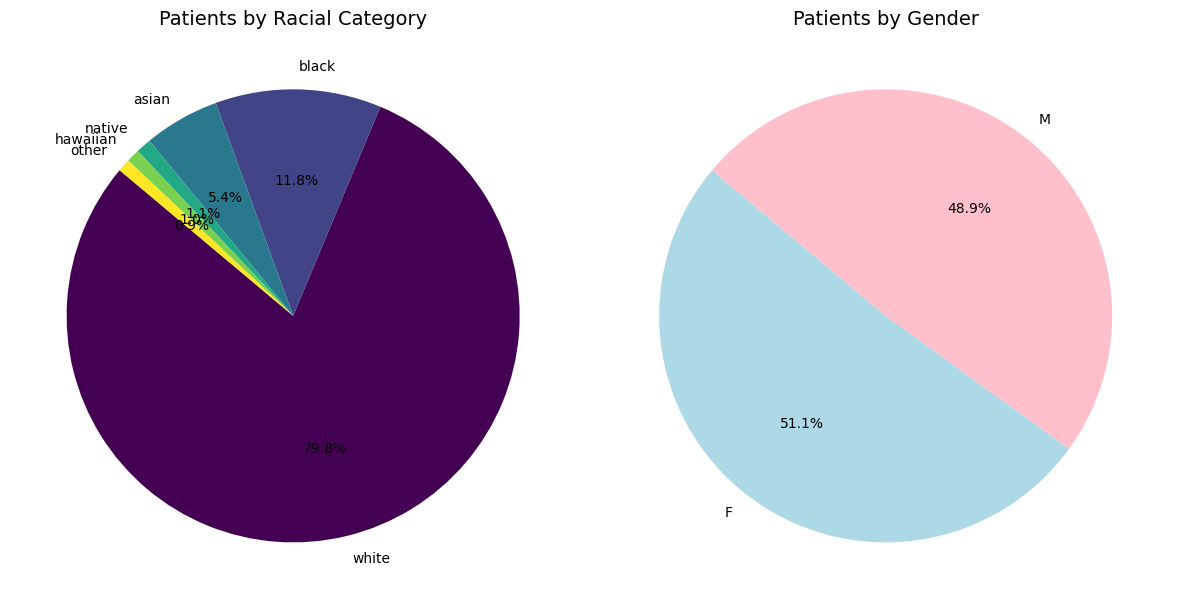

4. Calculating percentage of patients with all 4 symptom categories ≥ 30...
Percentage of patients with all 4 symptom categories ≥ 30: 0.00%

Data analysis and visualization completed.


In [ ]:
main()